In [34]:
# import the standard numerical and plotting packages
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

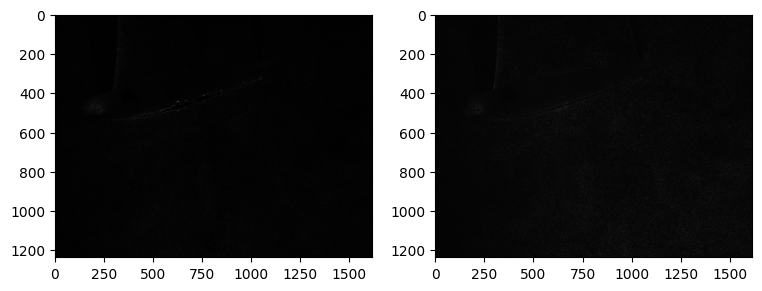

In [35]:
# load the images
im = imread("Pic1.tif")
a = im[:im.shape[0] // 2, :]
b = im[im.shape[0] // 2:, :]

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(a, cmap=plt.cm.gray)
axs[1].imshow(b, cmap=plt.cm.gray)
plt.show()


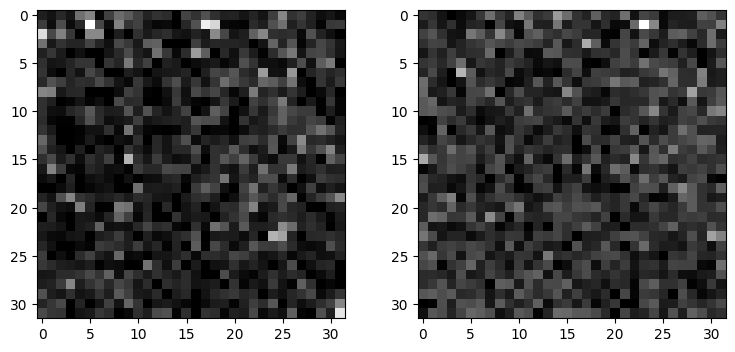

In [36]:
win_size = 32
a_win = a[:win_size, :win_size].copy()
b_win = b[:win_size, :win_size].copy()
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(a_win, cmap=plt.cm.gray)
axs[1].imshow(b_win, cmap=plt.cm.gray)
plt.show()


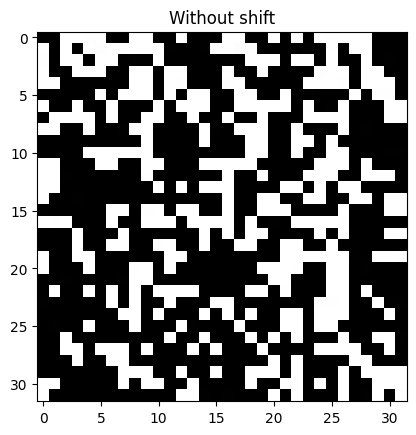

In [37]:
fig = plt.imshow(b_win - a_win, cmap=plt.cm.gray)
plt.title("Without shift")
plt.show()


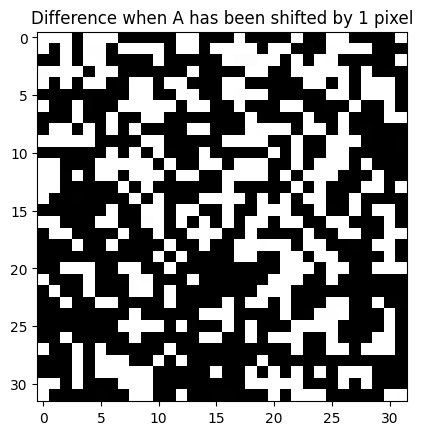

In [38]:
plt.imshow(b_win - np.roll(a_win, (1, 0), axis=(0, 1)), cmap=plt.cm.gray)
plt.title("Difference when A has been shifted by 1 pixel")
plt.show()

In [39]:
def match_template(img, template, maxroll=8):
    best_dist = np.inf
    best_shift = (-1, -1)
    for y in range(maxroll):
        for x in range(maxroll):
            # calculate Euclidean distance
            dist = np.sqrt(np.sum((img - np.roll(template, (y, x), axis=(0, 1))) **2))
        if dist < best_dist:
            best_dist = dist
            best_shift = (y, x)
    return (best_dist, best_shift)


In [40]:
match_template(np.roll(a_win, (2, 0), axis=(0, 1)), a_win)

(3539.33072769415, (5, 7))

In [41]:
# indeed, when we find the correct shift, we got zero distance. it's not so in real images
best_dist, best_shift = match_template(b_win, a_win)
print(f"{best_dist=}")
print(f"{best_shift=}")


best_dist=3539.495444268858
best_shift=(7, 7)


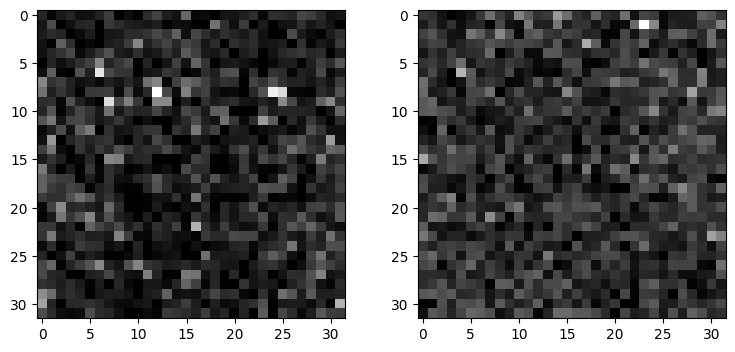

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(np.roll(a_win, best_shift, axis=(0, 1)), cmap='gray')
axs[1].imshow(b_win, cmap='gray')
plt.show()


In [43]:
from scipy.signal import correlate
cross_corr = correlate(b_win - b_win.mean(), a_win - a_win.mean(), method="fft")
# Note that it's approximately twice as large than the original windows, as we
# can shift a_win by a maximum of it's size - 1 horizontally and vertically
# while still maintaining some overlap between the two windows.
print("Size of the correlation map: %d x %d" % cross_corr.shape)


Size of the correlation map: 63 x 63


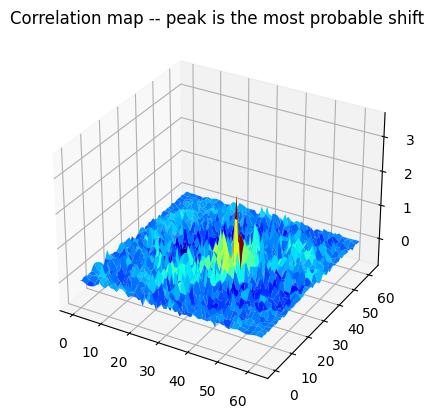

In [44]:
# let's see what the cross-correlation looks like
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
Y, X = np.meshgrid(np.arange(cross_corr.shape[0]), np.arange(cross_corr.shape[1]))
ax.plot_surface(Y, X, cross_corr, cmap='jet', linewidth=0.2) # type: ignore
plt.title("Correlation map -- peak is the most probable shift")
plt.show()


y=31, x=37


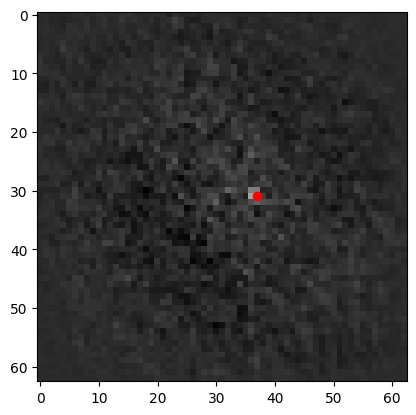

In [45]:
# let's see the same correlation map, from above
plt.imshow(cross_corr, cmap=plt.cm.gray)
y, x = np.unravel_index(cross_corr.argmax(), cross_corr.shape)
print(f"{y=}, {x=}")
plt.plot(x, y, "ro")
plt.show()


In [46]:
dy, dx = y - 31, x - 31
print(f"{dy=}, {dx=}")


dy=0, dx=6


In [78]:
def vel_field(curr_frame, next_frame, win_size):
    ys = np.arange(0, curr_frame.shape[0], win_size)
    xs = np.arange(0, curr_frame.shape[1], win_size)
    dys = np.zeros((len(ys), len(xs)))
    dxs = np.zeros((len(ys), len(xs)))
    for iy, y in enumerate(ys):
        for ix, x in enumerate(xs):
            int_win = curr_frame[y : y + win_size, x : x + win_size]
            search_win = next_frame[y : y + win_size, x : x + win_size]
            cross_corr = correlate( search_win - search_win.mean(), int_win - int_win.mean(), method="fft")
            dys[iy, ix], dxs[iy, ix] = (np.unravel_index(np.argmax(cross_corr), cross_corr.shape)- np.array([win_size, win_size])+ 1)
    # draw velocity vectors from the center of each window
    ys = ys + win_size / 2
    xs = xs + win_size / 2
    return xs, ys, dxs, dys


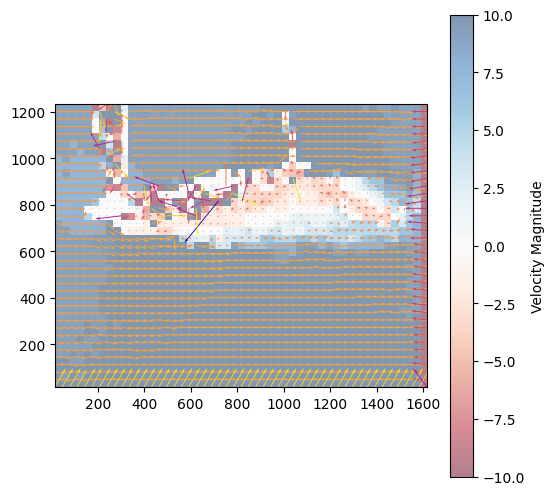

In [86]:
pitch = 4.4*10e-6
time = 73*10e-6
M = 0.04

xs, ys, dxs, dys = vel_field(a, b, 32)
u = dxs*pitch/(M*time)
v = dys*pitch/(M*time)


norm_drs = np.sign(dxs)*np.sqrt(dxs ** 2 + dys ** 2)
v = norm_drs*pitch/(M*time)
fig, ax = plt.subplots(figsize=(6, 6))
v_min = -10
v_max  = 10
# Add the heatmap of velocities as an overlay
heatmap = ax.imshow(v, extent=(xs.min(), xs.max(), ys.min(), ys.max()), cmap='RdBu', alpha=0.5,vmin=v_min, vmax=v_max)
# Add a colorbar for the heatmap
cbar = plt.colorbar(heatmap, label='Velocity Magnitude')

# we need these flips on y since quiver uses a bottom-left origin, while our
# arrays use a top-right origin
ax.quiver(xs, ys[::-1], dxs, -dys, norm_drs, cmap="plasma", angles="xy", scale_units="xy", scale=0.15)
ax.set_aspect("equal")
plt.show()


In [72]:
print(v)
min_value = np.min(v)
print(min_value)

[[ 9.04109589  9.04109589  9.04109589 ...  9.04109589  9.04109589
  15.06849315]
 [ 9.04109589  9.04109589  9.04109589 ...  9.04109589  9.04109589
  15.06849315]
 [ 9.04109589  9.04109589  9.04109589 ...  9.04109589  9.04109589
  15.06849315]
 ...
 [10.65503369 10.54794521 10.54794521 ... 10.54794521 10.54794521
  13.56164384]
 [10.54794521  9.16580655 10.54794521 ... 10.54794521 10.54794521
  13.56164384]
 [20.93381971 20.93381971 20.93381971 ... 20.93381971 20.93381971
  22.60273973]]
0.0


In [50]:
def vel_field_asymmetric_wins(curr_frame, next_frame, half_int_win_size, half_search_win_size):
    ys = np.arange(half_int_win_size[0], curr_frame.shape[0], 2 * half_int_win_size[0])
    xs = np.arange(half_int_win_size[1], curr_frame.shape[1], 2 * half_int_win_size[1])
    dys = np.zeros((len(ys), len(xs)))
    dxs = np.zeros((len(ys), len(xs)))
    for iy, y in enumerate(ys):
        for ix, x in enumerate(xs):
            int_win = curr_frame[y - half_int_win_size[0] : y + half_int_win_size[0],x - half_int_win_size[1] : x + half_int_win_size[1],]
            search_win_y_min = y - half_search_win_size[0]
            search_win_y_max = y + half_search_win_size[0]
            search_win_x_min = x - half_search_win_size[1]
            search_win_x_max = x + half_search_win_size[1]
            truncated_search_win = next_frame[max(0, search_win_y_min) : min(b.shape[0], search_win_y_max),max(0, search_win_x_min) : min(b.shape[1], search_win_x_max),]
            cross_corr = correlate(truncated_search_win - np.mean(truncated_search_win),int_win - np.mean(int_win),mode="valid",method="fft",)
            dy, dx = np.unravel_index(np.argmax(cross_corr), cross_corr.shape)
# if the top of the search window got truncated, shift the origin
# up to the top edge of the (non-truncated) search window
            if search_win_y_min < 0:
                dy += -search_win_y_min
# if the left of the search window got truncated, shift the origin
# over to the left edge of the (non-truncated) search window
            if search_win_x_min < 0:
                dx += -search_win_x_min
# shift origin to the center of the search window
            dy -= half_search_win_size[0] - half_int_win_size[0]
            dx -= half_search_win_size[1] - half_int_win_size[1]
            dys[iy, ix] = dy
            dxs[iy, ix] = dx
    return xs, ys, dxs, dys

In [51]:
int_win_size = np.array([32, 32])
print(f"{int_win_size=}")
#assert np.all(np.array(a.shape) % int_win_size == 0)
#assert np.all(int_win_size % 2 == 0)
half_int_win_size = int_win_size // 2
search_win_size = int_win_size * 2
print(f"{search_win_size=}")
#assert np.all(search_win_size % 2 == 0)
half_search_win_size = search_win_size // 2
#assert np.all(search_win_size > int_win_size)
print(
"max velocity that can be detected with these window sizes: "
+ f"{half_search_win_size - half_int_win_size}"
)


int_win_size=array([32, 32])
search_win_size=array([64, 64])
max velocity that can be detected with these window sizes: [16 16]


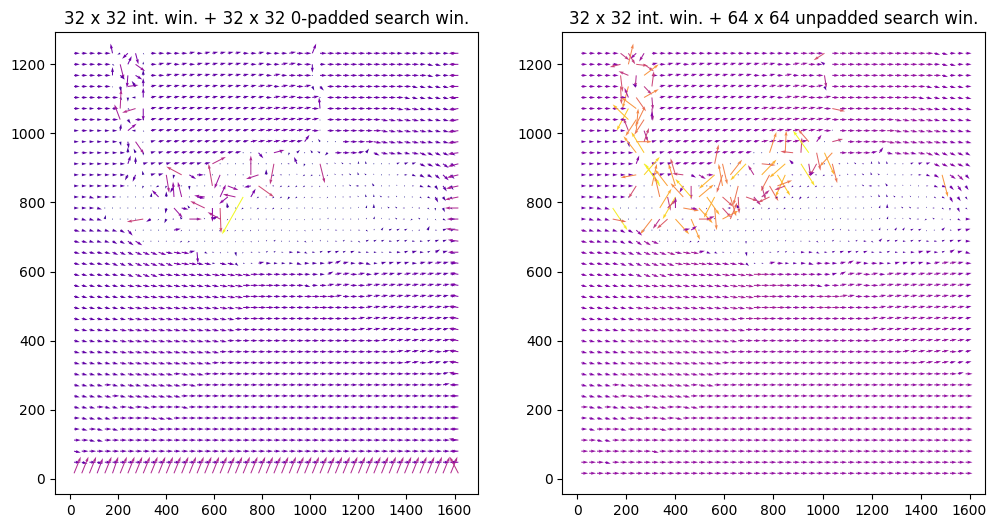

In [52]:
xs_asym, ys_asym, dxs_asym, dys_asym = vel_field_asymmetric_wins(a, b, half_int_win_size, half_search_win_size)
norm_drs_asym = np.sqrt(dxs_asym ** 2 + dys_asym ** 2)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].quiver(xs,ys[::-1],dxs,-dys,norm_drs,cmap="plasma",angles="xy",scale_units="xy",scale=0.25,)
axs[1].quiver(xs_asym,ys_asym[::-1],dxs_asym,-dys_asym,norm_drs_asym,cmap="plasma",angles="xy",scale_units="xy",scale=0.25,)
axs[0].set_title(f"{win_size} x {win_size} int. win. + "f"{win_size} x {win_size} 0-padded search win.")
axs[1].set_title(f"{int_win_size[0]} x {int_win_size[1]} int. win. + "f"{search_win_size[0]} x {search_win_size[0]} unpadded search win.")
ax.set_aspect("equal")
plt.show()

In [53]:
from openpiv import tools, pyprocess, validation, filters, scaling
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import imageio
import importlib_resources
import pathlib

path = importlib_resources.files('openpiv')


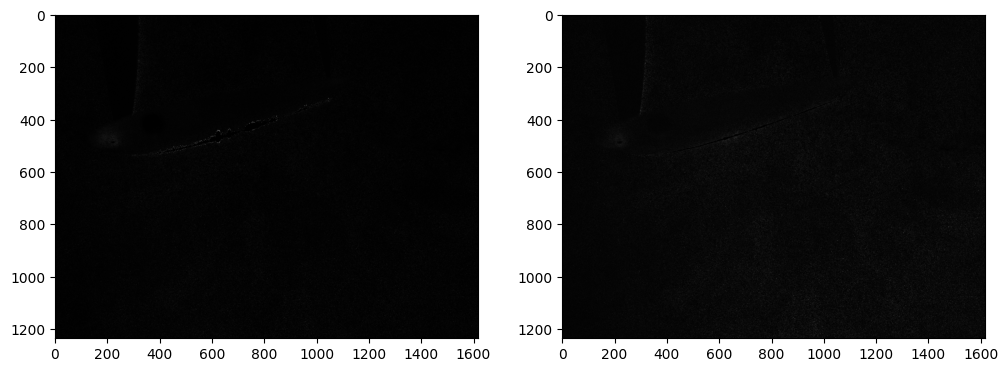

In [54]:
frame_a = a
frame_b = b
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray);
ax[1].imshow(frame_b,cmap=plt.cm.gray);


In [55]:
winsize = 32 # pixels, interrogation window size in frame A
searchsize = 38 # pixels, search area size in frame B
overlap = 17 # pixels, 50% overlap
dt = 0.02 # sec, time interval between the two frames
u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32),frame_b.astype(np.int32),window_size=winsize,overlap=overlap,dt=dt,search_area_size=searchsize,sig2noise_method='peak2peak',)


In [56]:
x, y = pyprocess.get_coordinates(image_size=frame_a.shape,search_area_size=searchsize,overlap=overlap,)

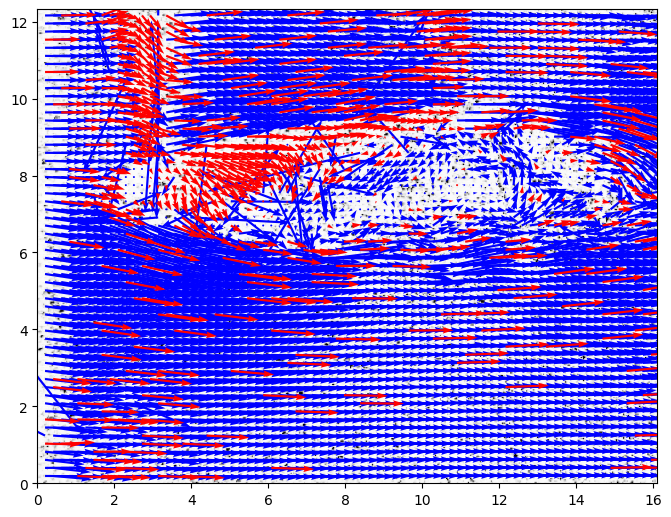

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [57]:
invalid_mask = validation.sig2noise_val(sig2noise,threshold = 1.05,)
u2, v2 = filters.replace_outliers(u0, v0,invalid_mask,method='localmean',max_iter=3,kernel_size=3,)
# convert x,y to mm
# convert u,v to mm/sec
x, y, u3, v3 = scaling.uniform(x, y, u2, v2,scaling_factor = 100, )
# 96.52 pixels/millimeter
# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)
tools.save('exp1_001.txt' , x, y, u3, v3, invalid_mask)
fig, ax = plt.subplots(figsize=(8,8))
# scale defines here the arrow length
# width is the thickness of the arrow
# overlay on the image
tools.display_vector_field(pathlib.Path('exp1_001.txt'),ax=ax, scaling_factor=96.52,scale=50,  width=0.0035, on_img=True, image_name= str(path / 'data'/'test1'/'exp1_001_a.bmp'),)


